#### <a href='https://www.kaggle.com/datasets/jruvika/fake-news-detection?datasetId=6410' target='_blank'>Fake News Detection</a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_dataset, Dataset
from ast import literal_eval

sns.set_theme()

In [2]:
df = pd.read_csv('data.csv')
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [3]:
df.columns

Index(['URLs', 'Headline', 'Body', 'Label'], dtype='object')

In [4]:
# [print(x) for x in df.Body.head()]

### Exploratory Data Analysis


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


#### !!! Body column contains null values !!!

In [6]:
### Drop null values
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      3988 non-null   object
 1   Headline  3988 non-null   object
 2   Body      3988 non-null   object
 3   Label     3988 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 155.8+ KB


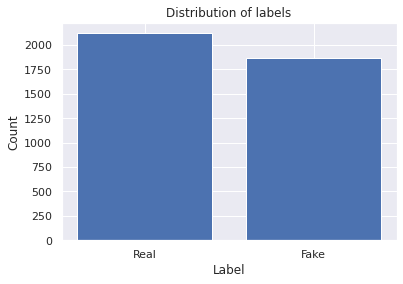

In [8]:
labels_distribution = df.Label.value_counts()
plt.bar(labels_distribution.index, labels_distribution.values)
plt.title('Distribution of labels')
plt.xticks(labels_distribution.index, ['Real', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [9]:
### Tokenize body using Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
def truncate_text(records_body):
    return tokenizer(records_body, truncation=True)

In [11]:
# from pyspark.sql import SparkSession
# from pyspark.sql import Row

# spark = SparkSession.builder.getOrCreate()
#
# spark_df = spark.createDataFrame(df)

In [12]:
# df.columns

In [13]:
# df.head()

In [14]:
# rdd = spark_df.rdd.map(lambda x: Row(
#     id=x.URLs,
#     label=x.Label,
#     body=x.Body,
#     truncated_body=truncate_text(x.Body)
# ))

In [15]:
# rdd.collect()
# print()

In [16]:
# convert to dataframe
# df_truncated = spark.createDataFrame(rdd)
# df_truncated = df_truncated.toPandas()

In [17]:
# df_truncated.head()

In [18]:
# training_data = pd.DataFrame(columns=['text', 'label', 'input_ids', 'attention_mask'], data=np.array(
#     list(zip(
#         df_truncated.body,
#         df_truncated.label,
#         [x[1]['input_ids'] for x in df_truncated.truncated_body],
#         [x[1]['attention_mask'] for x in df_truncated.truncated_body]
#     ))
# ))

In [19]:
# training_data.to_csv('dataset_truncated.csv', index=False)

In [20]:
dataset = pd.read_csv('dataset_truncated.csv')
dataset['attention_mask'] = [np.array(literal_eval(x)) for x in dataset['attention_mask']]
dataset['input_ids'] = [np.array(literal_eval(x)) for x in dataset['input_ids']]

dataset = Dataset.from_pandas(dataset)

### Create dataset

In [21]:
# train = training_data.iloc[:int(0.8*len(training_data))]
# y_train = training_data.label[:int(0.8*len(training_data))]
# test = training_data.iloc[int(0.8*len(training_data)):]
# y_test = training_data.label[int(0.8*len(training_data)):]

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [27]:
import wandb
wandb.login()

In [28]:
%env WANDB_PROJECT=fake_news_detection

In [29]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="wandb"
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [31]:
trainer.train()
wandb.finish()

### Evaluate model

#### For testing you need input_ids and attention_mask

In [2]:
true_news = 'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.'

fake_news = "JetNation FanDuel League; Week 4 of readers think this story is Fact. Add your two cents.(Before Its News)Our FanDuel league is back again this week. Here are the details:$900 in total prize money. $250 to the winner. $10 to enter.Remember this is a one week league, pick your lineup against the salary cap and next week if you want to play again you can pick a completely different lineup if you want.Click this link to enter — http://fanduel.com/JetNation You can discuss this with other NY Jets fans on the Jet Nation message board. Or visit of on Facebook.Source: http://www.jetnation.com/2017/09/27/jetnation-fanduel-league-week-4/"

In [34]:
tokenized_test = tokenizer(fake_news, truncation=True)
trainer.predict([tokenized_test])

In [35]:
tokenized_test = tokenizer(true_news, truncation=True)
trainer.predict([tokenized_test])

In [36]:
wandb.init()

In [37]:
trainer.evaluate(dataset)